# Visual Question Answering for Medical Images with Explainable AI

## Mounting the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing necessary libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from keras import backend
import torch
import torch.nn as nn
import re
from tqdm import tqdm
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import BertTokenizer
import random
import math
import matplotlib.pyplot as plt

In [ ]:
vocab_size = 4914
max_len = 1000
heads = 12
epochs = 999999
lr = 0.0001
clip = True
share = 'all'
norm = 'pre'
dim = 312
drop = 0.0
n_layers = 4
batch_size = 40
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device_name)
device = torch.device(device_name)
save_dir = './'

cuda:0


## Data Path

In [ ]:
Test_CSV = './Dataset/Test/Test_Data.csv'
Test_Images = './Dataset/Test/Test_Images/'

## Feature Extraction

### Image Feature Extraction

In [ ]:
Model_Path = './Image-Feature-Extraction-Model-960.h5'

In [ ]:
Image_Feature_Extraction_Model = tf.keras.models.load_model(Model_Path)
feature_func = backend.function([Image_Feature_Extraction_Model.input],[Image_Feature_Extraction_Model.layers[-2].output])

In [ ]:
def imagePreprocess(img):
  #resize
  resized_img = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

  return resized_img

In [ ]:
def getImageFeature(img_dir,img_name):
  img_path = img_dir+img_name+'.jpg'
  img = cv2.imread(img_path)
  pre_processed_img = imagePreprocess(img)
  img_feature = feature_func(np.array([pre_processed_img]))[0][0]
  return [math.ceil(x)+100 for x in img_feature]

In [ ]:
def getImageFeature_1(img):
  pre_processed_img = imagePreprocess(img)
  img_feature = feature_func(np.array([pre_processed_img]))[0][0]
  return [math.ceil(x)+100 for x in img_feature]

### Question Feature Extraction

In [ ]:
def textPreprocess(txt):
  #lower case
  txt = txt.lower()

  txt = re.sub('-',' ',txt)

  return  re.sub('[^a-zA-Z0-9#]',' ',txt)

In [ ]:
Vocab_Path = './bert-tokenizer'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(Vocab_Path)

In [ ]:
def getTokenizedText(txt):
  return list(tokenizer(txt)['input_ids'][1:-1])

## Loading the Data

In [ ]:
def extract_data(file):
    imag, ques, answ = [],[],[]
    df = pd.read_csv(file,header=None)
    #print(df.head)
    for line in df.index:
        imag.append(df[0][line])
        ques.append(textPreprocess(df[1][line]))
        answ.append(textPreprocess(df[2][line]))
    return imag, ques, answ

In [ ]:
def gene_data(text_file):
    _imag, _ques, _answ = extract_data(text_file)
    ge_imag, ge_ques, ge_answ = [], [], []
    for i in range(len(_imag)):
        ge_imag.append(_imag[i])
        ge_ques.append(_ques[i])
        ge_answ.append(_answ[i])
    state = np.random.get_state()
    np.random.shuffle(ge_imag)
    np.random.set_state(state)
    np.random.shuffle(ge_ques)
    np.random.set_state(state)
    np.random.shuffle(ge_answ)
    return ge_imag, ge_ques, ge_answ

In [ ]:
test_imag, test_ques, test_answ = gene_data(Test_CSV)

In [ ]:
def get_data(file,start,end):
    imag, ques, answ = [],[],[]
    df = pd.read_csv(file,header=None)
    for i in range(start,end+1):
        imag.append(df[0][i])
        ques.append(textPreprocess(df[1][i]))
        answ.append(textPreprocess(df[2][i]))
    return imag, ques, answ

In [ ]:
mod_img,mod_ques,mod_ans = get_data(Test_CSV,0,124)
plane_img,plane_ques,plane_ans = get_data(Test_CSV,125,249)
org_img,org_ques,org_ans = get_data(Test_CSV,250,374)
abn_img,abn_ques,abn_ans = get_data(Test_CSV,375,499)

## Special Tokens of BERT

In [ ]:
CLS = getTokenizedText('[CLS]')
SEP = getTokenizedText('[SEP]')
MASK = getTokenizedText('[MASK]')

## VQA Model Modules

In [ ]:
def gelu(x):
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [ ]:
class Embeddings(nn.Module):
    def __init__(self,max_len):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, 128, padding_idx=0)
        self.word_embeddings_2 = nn.Linear(128, dim, bias=False)
        self.position_embeddings = nn.Embedding(max_len, dim)
        self.type_embeddings = nn.Embedding(3, dim)
        self.LayerNorm = nn.LayerNorm(dim, eps=1e-12)
        self.dropout = nn.Dropout(drop)
        self.len = max_len
    def forward(self, input_ids, segment_ids, position_ids=None):
        #print(input_ids)
        input_ids = torch.cuda.LongTensor(input_ids)
        segment_ids = torch.cuda.LongTensor(segment_ids)
        if position_ids is None:
            position_ids = torch.arange(self.len, dtype=torch.long, device=device)
            position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        words_embeddings = self.word_embeddings(input_ids)
        words_embeddings = self.word_embeddings_2(words_embeddings)
        position_embeddings = self.position_embeddings(position_ids)
        token_type_embeddings = self.type_embeddings(segment_ids)
        embeddings = words_embeddings + position_embeddings + token_type_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

In [ ]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj_q = nn.Linear(dim, dim)
        self.proj_k = nn.Linear(dim, dim)
        self.proj_v = nn.Linear(dim, dim)
        self.drop = nn.Dropout(drop)
        self.scores = None
        self.n_heads = heads
    def forward(self, x, mask):
        q, k, v = self.proj_q(x), self.proj_k(x), self.proj_v(x)
        q, k, v = (self.split_last(x, (self.n_heads, -1)).transpose(1, 2) for x in [q, k, v])
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1))
        if mask is not None:
            mask = mask[:, None, None, :].float()
            scores -= 10000.0 * (1.0 - mask)
        scores = self.drop(F.softmax(scores, dim=-1))
        h = (scores @ v).transpose(1, 2).contiguous()
        h = self.merge_last(h, 2)
        self.scores = scores
        return h
    def split_last(self, x, shape):
        shape = list(shape)
        assert shape.count(-1) <= 1
        if -1 in shape:
            shape[shape.index(-1)] = int(x.size(-1) / -np.prod(shape))
        return x.view(*x.size()[:-1], *shape)
    def merge_last(self, x, n_dims):
        s = x.size()
        assert n_dims > 1 and n_dims < len(s)
        return x.view(*s[:-n_dims], -1)

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim*4)
        self.fc2 = nn.Linear(dim*4, dim)
    def forward(self, x):
        return self.fc2(gelu(self.fc1(x)))

In [ ]:
class BertLayer(nn.Module):
    def __init__(self, share='all', norm='pre'):
        super(BertLayer, self).__init__()
        self.share = share
        self.norm_pos = norm
        self.norm1 = nn.LayerNorm(dim, eps=1e-12)
        self.norm2 = nn.LayerNorm(dim, eps=1e-12)
        self.drop1 = nn.Dropout(drop)
        self.drop2 = nn.Dropout(drop)
        if self.share == 'ffn':
            self.attention = nn.ModuleList([MultiHeadedSelfAttention() for _ in range(n_layers)])
            self.proj = nn.ModuleList([nn.Linear(dim, dim) for _ in range(n_layers)])
            self.feedforward = PositionWiseFeedForward()
        elif self.share == 'att':
            self.attention = MultiHeadedSelfAttention()
            self.proj = nn.Linear(dim, dim)
            self.feedforward = nn.ModuleList([PositionWiseFeedForward() for _ in range(n_layers)])
        elif self.share == 'all':
            self.attention = MultiHeadedSelfAttention()
            self.proj = nn.Linear(dim, dim)
            self.feedforward = PositionWiseFeedForward()
        elif self.share == 'none':
            self.attention = nn.ModuleList([MultiHeadedSelfAttention() for _ in range(n_layers)])
            self.proj = nn.ModuleList([nn.Linear(dim, dim) for _ in range(n_layers)])
            self.feedforward = nn.ModuleList([PositionWiseFeedForward() for _ in range(n_layers)])
    def forward(self, hidden_states, attention_mask, layer_num):
        attention_mask = torch.cuda.LongTensor(attention_mask)
        if self.norm_pos == 'pre':
            if isinstance(self.attention, nn.ModuleList):
                h = self.proj[layer_num](self.attention[layer_num](self.norm1(hidden_states), attention_mask))
            else:
                h = self.proj(self.attention(self.norm1(hidden_states), attention_mask))
            out = hidden_states + self.drop1(h)
            if isinstance(self.feedforward, nn.ModuleList):
                h = self.feedforward[layer_num](self.norm1(out))
            else:
                h = self.feedforward(self.norm1(out))
            out = out + self.drop2(h)
        if self.norm_pos == 'post':
            if isinstance(self.attention, nn.ModuleList):
                h = self.proj[layer_num](self.attention[layer_num](hidden_states, attention_mask))
            else:
                h = self.proj(self.attention(hidden_states, attention_mask))
            out = self.norm1(hidden_states + self.drop1(h))
            if isinstance(self.feedforward, nn.ModuleList):
                h = self.feedforward[layer_num](out)
            else:
                h = self.feedforward(out)
            out = self.norm2(out + self.drop2(h))
        return out

In [ ]:
class Transformer(nn.Module):
    def __init__(self,max_len=max_len):
        super().__init__()
        self.embed = Embeddings(max_len)
        self.blocks = BertLayer(share='none', norm='pre')
        self.n_layers = n_layers
    def forward(self, x, seg, mask):
        h = self.embed(x, seg)
        for i in range(self.n_layers):
            h = self.blocks(h, mask, i)
        return h

## VQA Model Class

In [ ]:
class VQAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = Transformer(max_len)
        self.fc2 = nn.Linear(dim, dim)
        self.norm = nn.LayerNorm(dim, eps=1e-12)
        embed_weight = self.transformer.embed.word_embeddings.weight
        n_vocab, embed_dim = embed_weight.size()
        self.decoder = nn.Linear(dim, embed_dim, bias=False)
        self.decoder_2 = nn.Linear(embed_dim, n_vocab, bias=False)
        self.decoder_2.weight = embed_weight
        self.decoder_bias = nn.Parameter(torch.zeros(n_vocab))
    def forward(self, input_ids, segment_ids, input_mask, masked_pos):
        h = self.transformer(input_ids, segment_ids, input_mask)
        masked_pos = torch.cuda.LongTensor(masked_pos)[:, :, None].expand(-1, -1, h.size(-1))
        h_masked = torch.gather(h, 1, masked_pos)
        h_masked = self.norm(gelu(self.fc2(h_masked)))
        logits_lm = self.decoder_2(self.decoder(h_masked)) + self.decoder_bias
        return logits_lm

In [ ]:
dict_op = {value:key for key, value in dict(tokenizer.vocab).items()}

## Loading the Model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
VQA_Model_Path = './model-final.pt'
VQA_Model = VQAModel().to(device)
VQA_Model.load_state_dict(torch.load(VQA_Model_Path))
VQA_Model.eval()

VQAModel(
  (transformer): Transformer(
    (embed): Embeddings(
      (word_embeddings): Embedding(4914, 128, padding_idx=0)
      (word_embeddings_2): Linear(in_features=128, out_features=312, bias=False)
      (position_embeddings): Embedding(1000, 312)
      (type_embeddings): Embedding(3, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): BertLayer(
      (norm1): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (norm2): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (drop1): Dropout(p=0.0, inplace=False)
      (drop2): Dropout(p=0.0, inplace=False)
      (attention): ModuleList(
        (0-3): 4 x MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=312, out_features=312, bias=True)
          (proj_k): Linear(in_features=312, out_features=312, bias=True)
          (proj_v): Linear(in_features=312, out_features=312, bias=True)
          (drop): Dropout(

## Answer Generation Function

In [ ]:
def generateAnswer_1(image,question):
    part1 = getImageFeature_1(image)
    part2 = getTokenizedText(textPreprocess(question))
    tokens = []
    tokens = CLS + part1 + SEP + part2 + SEP + MASK
    masked_pos = [len(part1+part2)+3]
    segment_ids = [0]*(len(part1)+2) + [1]*(len(part2)+1) + [2]*(1)
    input_mask = [1]*(len(part1+part2)+4)
    n_pad = max_len - len(part1+part2) - 4
    tokens.extend([0]*(n_pad))
    segment_ids.extend([0]*n_pad)
    input_mask.extend([0]*n_pad)
    output = []
    #print("Generating Answers...")
    for k in range(n_pad):
        with torch.no_grad():
            pred = VQA_Model([tokens], [segment_ids], [input_mask], [masked_pos])
            out = int(np.argsort((pred.cpu())[0][0])[-1])
            if(out>len(dict_op)):
                out=1
            #print(dict_op[out])
            output.append(dict_op[out])
            if out == 3:
                break
            else:
                tokens[len(part1+part2)+3+k] = out
                tokens[len(part1+part2)+4+k] = MASK[0]
                masked_pos = [len(part1+part2)+4+k]
                segment_ids = [0]*(len(part1)+2) + [1]*(len(part2)+1) + [2]*(2+k)
                input_mask = [1]*(len(part1+part2)+5+k)
                n_pad = n_pad - 1
                segment_ids.extend([0]*n_pad)
                input_mask.extend([0]*n_pad)
    print((' '.join(output)).replace(' ##','').replace('[SEP]','').replace(', ',''))

## LIME

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=895c1127327772e4dd0278231358e83b95d93d33adf02befac7a57569c58f6b4
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
import lime
from lime import lime_image
from lime import submodular_pick

In [ ]:
import matplotlib.cm as c_map
from skimage.segmentation import mark_boundaries

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    plt.axis('off')
    plt.show()

def explanation_heatmap(exp, exp_class):
    '''
    Using heat-map to highlight the importance of each super-pixel for the model prediction
    '''
    dict_heatmap = dict(exp.local_exp[exp_class])
    heatmap = np.vectorize(dict_heatmap.get)(exp.segments) 
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    #plt.show()



In [ ]:
def predict_2(img):
  results = []
  for i in range(len(img)):
    plt.imshow(img[i])
    plt.show()
    part1 = getImageFeature_1(img[i])
    question = 'what is the organ depicted this image?'
    question = textPreprocess(question)
    part2 = getTokenizedText(question)
    tokens = []
    tokens = CLS + part1 + SEP + part2 + SEP + MASK
    masked_pos = [len(part1+part2)+3]
    segment_ids = [0]*(len(part1)+2) + [1]*(len(part2)+1) + [2]*(1)
    input_mask = [1]*(len(part1+part2)+4)
    n_pad = max_len - len(part1+part2) - 4
    tokens.extend([0]*(n_pad))
    segment_ids.extend([0]*n_pad)
    input_mask.extend([0]*n_pad)
    outputs = VQA_Model([tokens], [segment_ids], [input_mask], [masked_pos])
    logits = outputs[0]
    logits = F.softmax(logits, dim = 1)
    results.append(logits.cpu().detach().numpy()[0])
  return np.array(results)

In [ ]:
image_path = './Dataset/Test/Test_Images/'

In [ ]:
explainer = lime_image.LimeImageExplainer()

  0%|          | 0/5 [00:00<?, ?it/s]

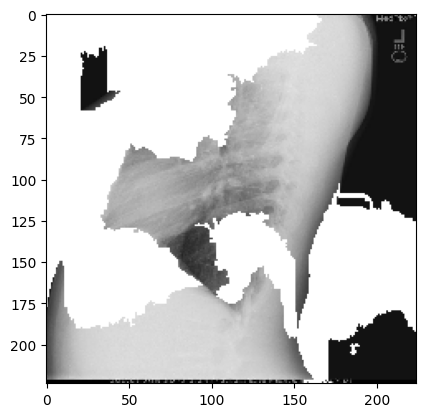

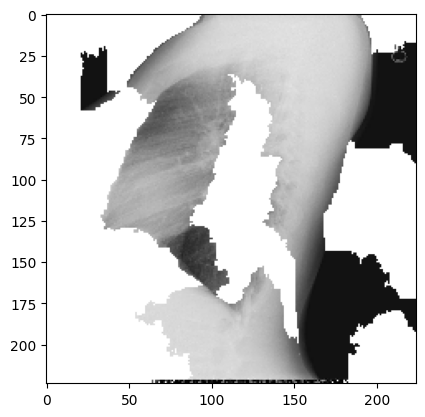

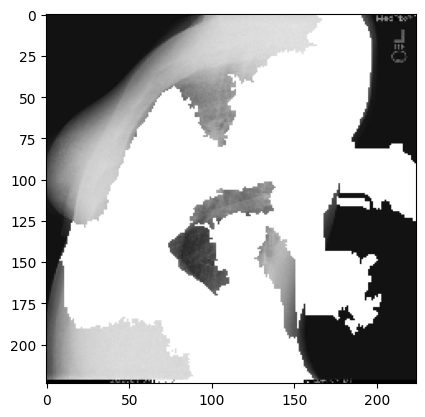

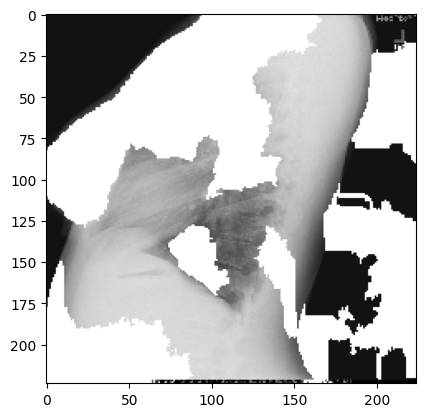

In [ ]:
image_name = 'synpic16734'
image = cv2.imread(image_path+image_name+'.jpg')
image = imagePreprocess(image)
exp = explainer.explain_instance(image, 
                                 predict_2, 
                                 top_labels=1, 
                                 hide_color=255, 
                                 num_samples=5)

In [ ]:
class Prediction:
  def __init__(self,question):
    self.model = VQA_Model
    self.question = question
  def predict(self,img):
    results = []
    for i in range(len(img)):
      part1 = getImageFeature_1(img[i])
      question = textPreprocess(self.question)
      part2 = getTokenizedText(question)
      tokens = []
      tokens = CLS + part1 + SEP + part2 + SEP + MASK
      masked_pos = [len(part1+part2)+3]
      segment_ids = [0]*(len(part1)+2) + [1]*(len(part2)+1) + [2]*(1)
      input_mask = [1]*(len(part1+part2)+4)
      n_pad = max_len - len(part1+part2) - 4
      tokens.extend([0]*(n_pad))
      segment_ids.extend([0]*n_pad)
      input_mask.extend([0]*n_pad)
      outputs = self.model([tokens], [segment_ids], [input_mask], [masked_pos])
      logits = outputs[0]
      logits = F.softmax(logits, dim = 1)
      results.append(logits.cpu().detach().numpy()[0])
    return np.array(results)

In [ ]:
def getExplanations(image,question):
  image = imagePreprocess(image)
  Predictor = Prediction(question)
  generateAnswer_1(image,question)
  exp = explainer.explain_instance(image, 
                                 Predictor.predict, 
                                 top_labels=1, 
                                 hide_color=127, 
                                 num_samples=1000)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  
  plt.imshow(exp.segments)
  plt.axis('off')
  plt.show()

  generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

  generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

  generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

  explanation_heatmap(exp, exp.top_labels[0])

us ultrasound 


  0%|          | 0/1000 [00:00<?, ?it/s]

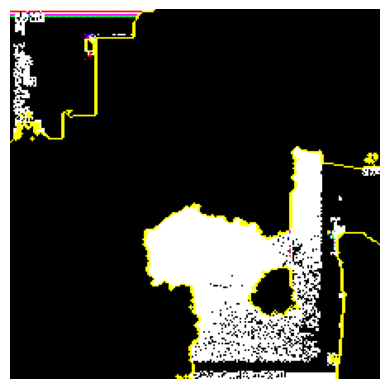

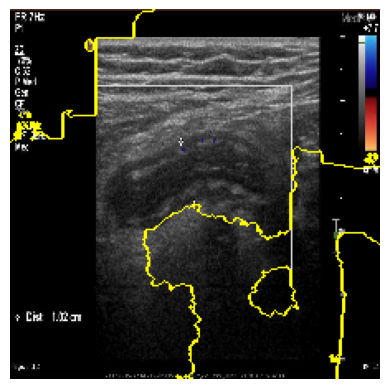

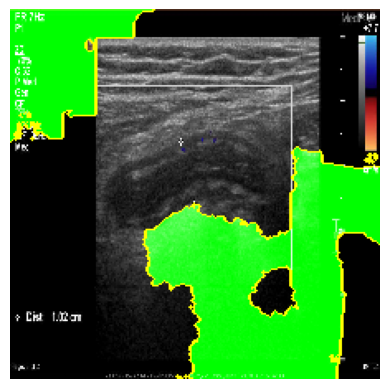

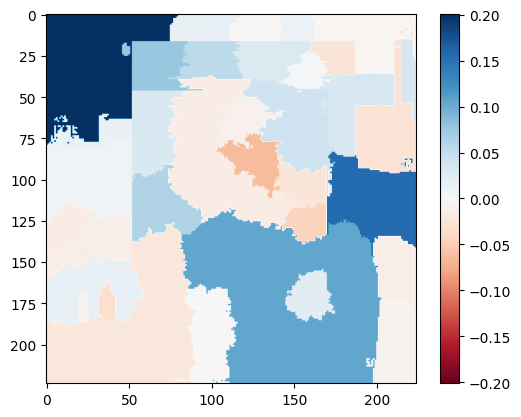

In [ ]:
image_name = 'synpic46949'
image = cv2.imread(image_path+image_name+'.jpg')
getExplanations(image,'what is the modality of this image?')

In [ ]:
def getExplanations_v2(image,question):
  image = imagePreprocess(image)
  Predictor = Prediction(question)
  generateAnswer_1(image,question)
  exp = explainer.explain_instance(image, 
                                 Predictor.predict, 
                                 top_labels=1, 
                                 hide_color=127, 
                                 num_samples=1000)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

  #generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

  #generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = False)

  generate_prediction_sample(exp, exp.top_labels[0], show_positive = False, hide_background = False)

  #explanation_heatmap(exp, exp.top_labels[0])

skull and contents 


  0%|          | 0/1000 [00:00<?, ?it/s]

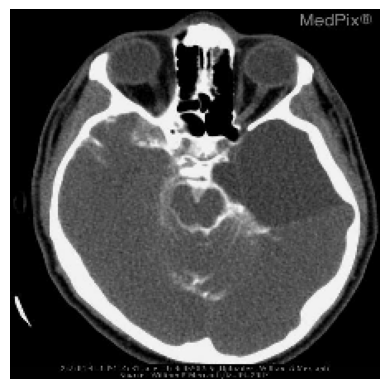

skull and contents 


  0%|          | 0/1000 [00:00<?, ?it/s]

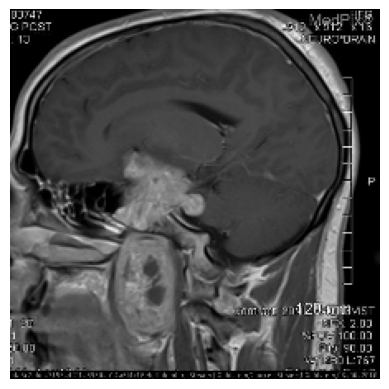

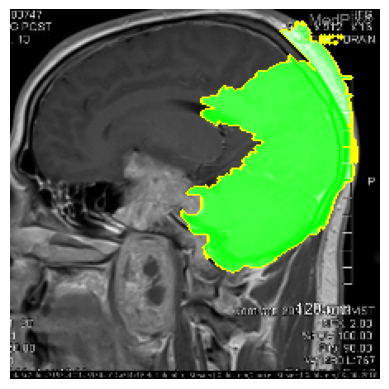

skull and contents 


  0%|          | 0/1000 [00:00<?, ?it/s]

skull and contents 


  0%|          | 0/1000 [00:00<?, ?it/s]

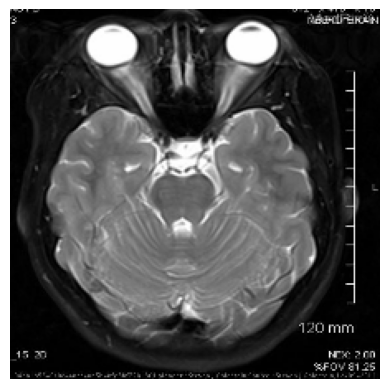

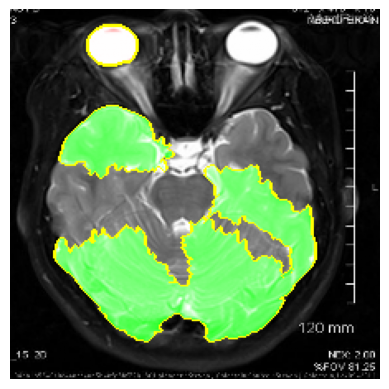

avm 


  0%|          | 0/1000 [00:00<?, ?it/s]

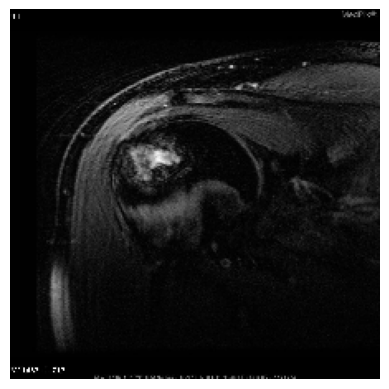

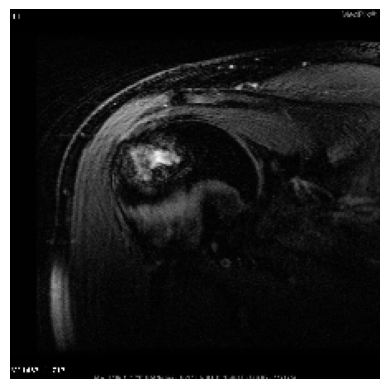

genitourinary 


  0%|          | 0/1000 [00:00<?, ?it/s]

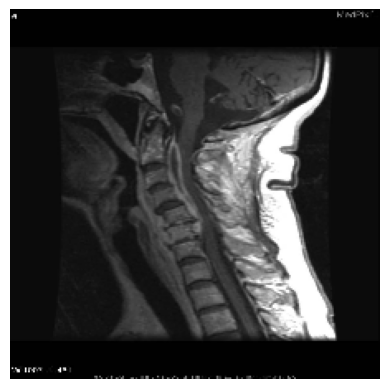

In [ ]:
for i in ['synpic16333', 'synpic53848', 'synpic31015', 'synpic56918', 'synpic26227', 'synpic31996']:
  image = cv2.imread(image_path+i+'.jpg')
  getExplanations_v2(image,'what organ system is displayed in this image?')

what type of imaging modality is shown?
mr t2 weighted 


  0%|          | 0/1000 [00:00<?, ?it/s]

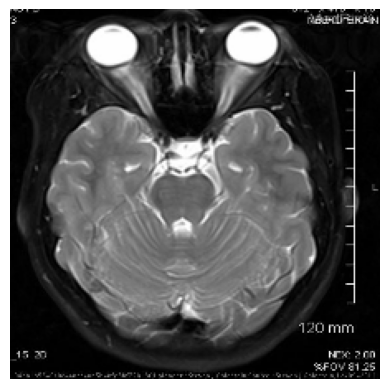

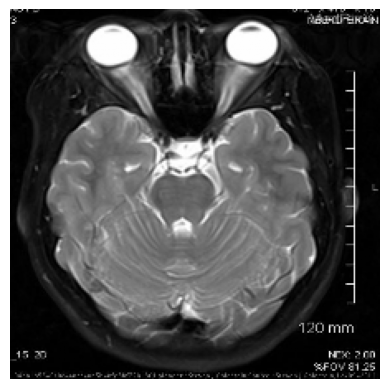

What is the plane of this image?
axial 


  0%|          | 0/1000 [00:00<?, ?it/s]

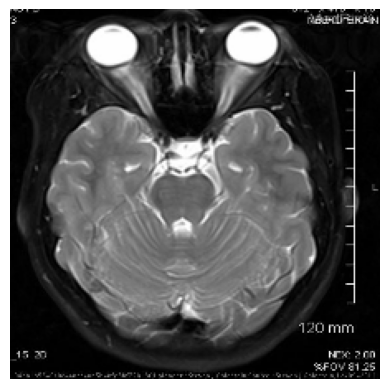

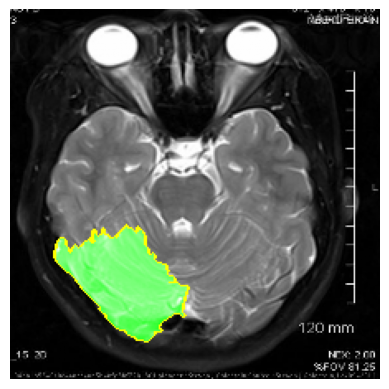

what organ system is displayed in this image?
skull and contents 


  0%|          | 0/1000 [00:00<?, ?it/s]

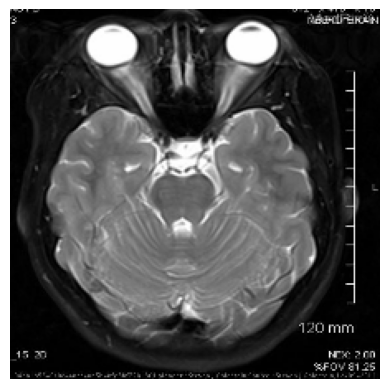

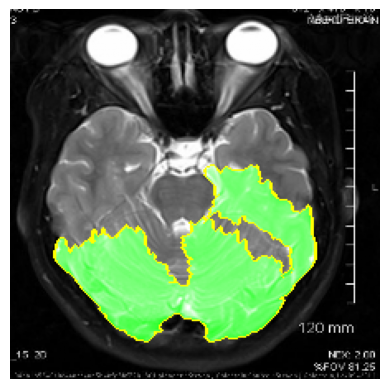

what is the primary abnormality in this image?
cavernous hemangioma 


  0%|          | 0/1000 [00:00<?, ?it/s]

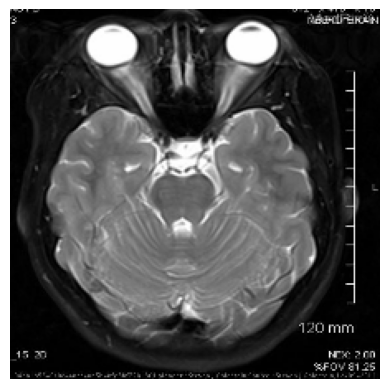

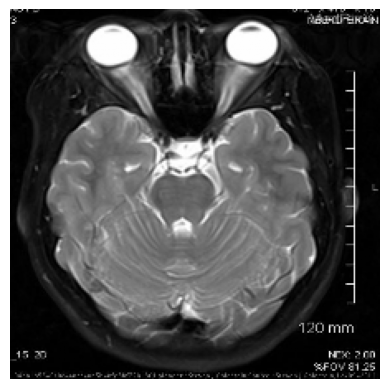

In [ ]:
qns = ["what type of imaging modality is shown?",
       "What is the plane of this image?",
       "what organ system is displayed in this image?",
       "what is the primary abnormality in this image?"]
for i in qns:
  image = cv2.imread(image_path+'synpic56918'+'.jpg')
  print(i)
  getExplanations_v2(image,i)

## SHAP

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 26.5 MB/s eta 0:00:00


In [ ]:
import shap

In [ ]:
class FinalModel(nn.Module):
  def __init__(self, question):
        super().__init__()
        self.question = question
        self.model = VQA_Model
  def forward(self, images):
        result = []
        for image in images:
          part1 = getImageFeature_1(imagePreprocess(np.asarray(image)))
          question1 = textPreprocess(self.question)
          part2 = getTokenizedText(question1)
          tokens = []
          tokens = CLS + part1 + SEP + part2 + SEP + MASK
          masked_pos = [len(part1+part2)+3]
          segment_ids = [0]*(len(part1)+2) + [1]*(len(part2)+1) + [2]*(1)
          input_mask = [1]*(len(part1+part2)+4)
          n_pad = max_len - len(part1+part2) - 4
          tokens.extend([0]*(n_pad))
          segment_ids.extend([0]*n_pad)
          input_mask.extend([0]*n_pad)
          output = self.model([tokens], [segment_ids], [input_mask], [masked_pos])
          logits = output[0]
          logits = F.softmax(logits, dim = 1)
          result.append(logits.cpu().detach().numpy()[0])
        result = np.array(result)
        return torch.tensor(result)

In [ ]:
class FinalModel2(nn.Module):
  def __init__(self, question):
        super().__init__()
        self.question = question
        self.model = VQA_Model
        self.i = 0
  def forward(self, images):
        result = []
        #print(len(images))
        for image in images:
          if self.i < 5:
            self.i += 1
            plt.imshow(image)
            plt.show()
          part1 = getImageFeature_1(imagePreprocess(np.asarray(image)))
          question1 = textPreprocess(self.question)
          part2 = getTokenizedText(question1)
          tokens = []
          tokens = CLS + part1 + SEP + part2 + SEP + MASK
          masked_pos = [len(part1+part2)+3]
          segment_ids = [0]*(len(part1)+2) + [1]*(len(part2)+1) + [2]*(1)
          input_mask = [1]*(len(part1+part2)+4)
          n_pad = max_len - len(part1+part2) - 4
          tokens.extend([0]*(n_pad))
          segment_ids.extend([0]*n_pad)
          input_mask.extend([0]*n_pad)
          output = self.model([tokens], [segment_ids], [input_mask], [masked_pos])
          logits = output[0]
          logits = F.softmax(logits, dim = 1)
          result.append(logits.cpu().detach().numpy()[0])
        result = np.array(result)
        return torch.tensor(result)

In [ ]:
test_csv_actual = '/content/drive/MyDrive/Final Year Project - Deepananth & Jayakrishnan - VQA/Second Review/VQA-Model/Model-960-Version-2/Dataset/Test/Test_Data.csv'
test_images_actual = '/content/drive/MyDrive/Final Year Project - Deepananth & Jayakrishnan - VQA/Second Review/VQA-Model/Model-960-Version-2/Dataset/Test/Test_Images/'

In [ ]:
test_df = pd.read_csv(test_csv_actual,header=None)
test_input_1 = list(test_df[0][250:375][:6])
test_input = [imagePreprocess(cv2.imread(test_images_actual+i+'.jpg')) for i in test_input_1]

In [ ]:
shap.initjs()

In [ ]:
masker = shap.maskers.Image("inpaint_telea", (224,224,3))

In [ ]:
class_labels = [value for value in dict_op.values()]

In [ ]:
Model_2 = FinalModel2('what organ system is displayed in this image?')

In [ ]:
explainer_shap = shap.Explainer(Model_2, masker, output_names=None)

In [ ]:
#list(test_input_1)

['synpic16333',
 'synpic53848',
 'synpic31015',
 'synpic56918',
 'synpic26227',
 'synpic31996']

In [ ]:
#list(test_df[2][250:375][:6])

['skull and contents',
 'skull and contents',
 'face, sinuses, and neck',
 'skull and contents',
 'musculoskeletal',
 'spine and contents']

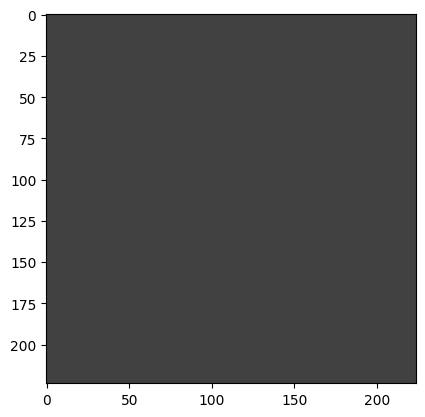

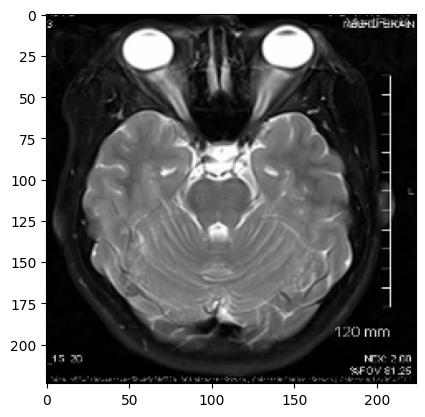

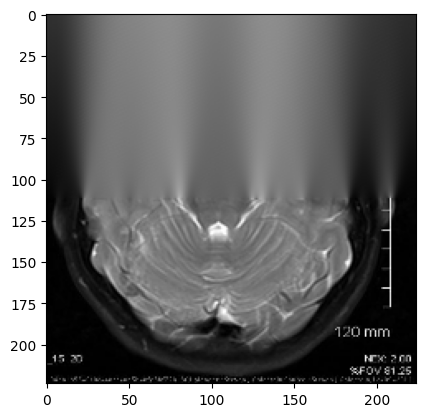

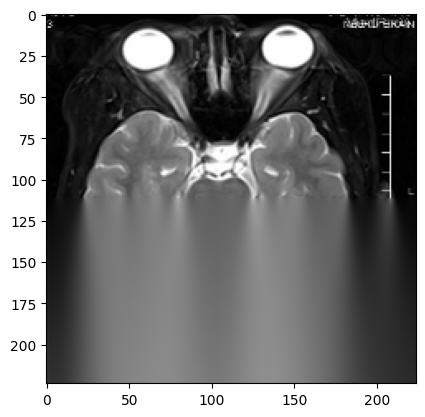

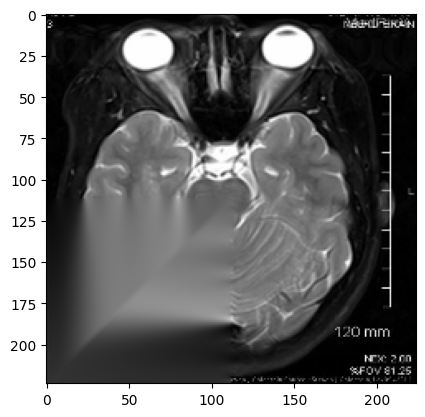

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:39, 39.11s/it]               


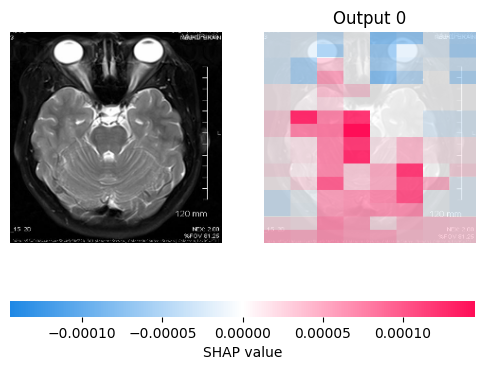

In [ ]:
shap_values = explainer_shap(np.array([test_input[3]]), outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

In [ ]:
Model_1 = FinalModel2('what organ system is displayed in this image?')

In [ ]:
explainer_shap = shap.Explainer(Model_1, masker, output_names=None)

  0%|          | 0/498 [00:00<?, ?it/s]


Partition explainer: 2it [00:25, 25.68s/it]               


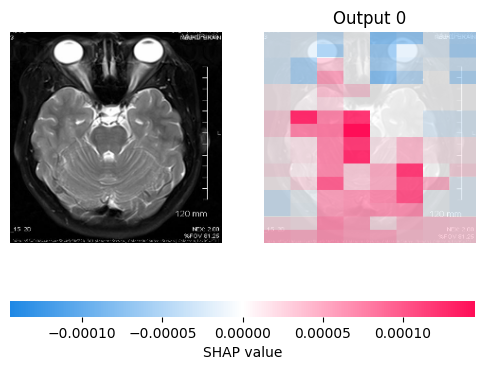

In [ ]:
shap_values = explainer_shap(np.array([test_input[3]]), outputs=shap.Explanation.argsort.flip[:1])
shap.image_plot(shap_values)

In [ ]:
def singleImageMultipleAnswer(image1):
  qns = ["what type of imaging modality is shown?",
         "What is the plane of this image?",
         "what organ system is displayed in this image?",
         "what is the primary abnormality in this image?"]

  for qn in qns:
    print(qn)
    generateAnswer_1(image1,qn)
    Model_q = FinalModel(qn)
    explainer_1 = shap.Explainer(Model_q, masker, output_names=None)
    shap_values_1 = explainer_1(np.array([image1]), outputs=shap.Explanation.argsort.flip[:1])
    shap.image_plot(shap_values_1)

what type of imaging modality is shown?
mr t2 weighted 


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:46, 46.74s/it]               


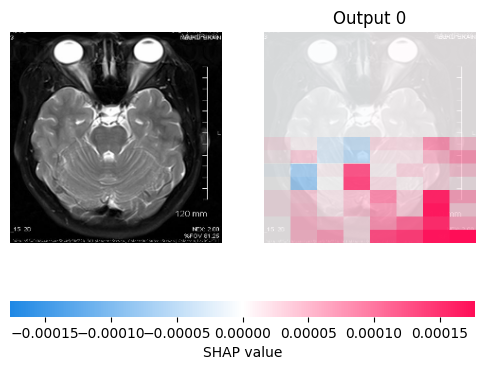

What is the plane of this image?
axial 


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:45, 45.92s/it]               


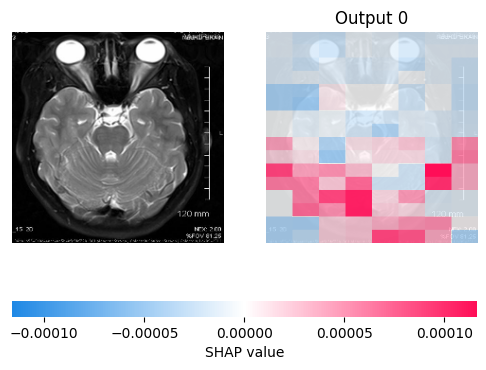

what organ system is displayed in this image?
skull and contents 


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:26, 26.38s/it]               


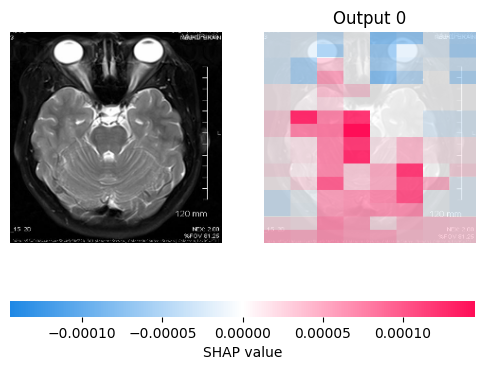

what is the primary abnormality in this image?
cavernous hemangioma 


  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 2it [00:20, 20.58s/it]               


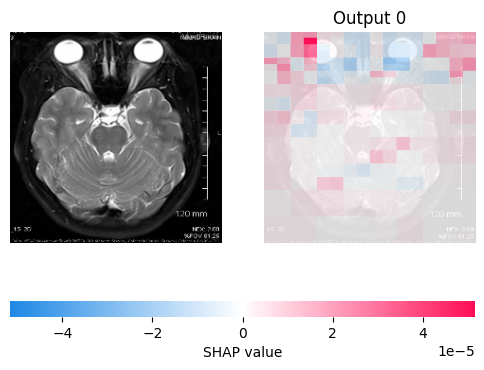

In [ ]:
img_name = 'synpic56918'
input_image = imagePreprocess(cv2.imread(test_images_actual+img_name+'.jpg'))
singleImageMultipleAnswer(input_image)